# Data Assignment 1 - `t54zheng` (20939203)

## Task 4 - Mean-variance Analysis

In [1]:
# imports

import pandas as pd
import scipy.stats as stats
from math import sqrt
import warnings
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

In [2]:
# Import raw data
data_file = "djreturns.xlsx"

dj27 = pd.read_excel(data_file, sheet_name="dj27")
individual_dj27_returns = pd.read_excel(data_file, sheet_name="returns")
sp500_returns = pd.read_excel(data_file, sheet_name="sp500")

In [3]:
# Also we carry forward the returns df from Task 2

returns_dict = {} # permno -> dataframe(permno_returns)
permnos = dj27["PERMNO"]
for permno in permnos:
    returns_df = individual_dj27_returns[individual_dj27_returns["PERMNO"] == permno]
    returns_dict[permno] = returns_df

***

a) We will find the global minimum variance portfolio using the aggregate data from 2000-2021

We already computed each stock's **annualized** average monthly return and standard deviation in `stats_df`, so we can use this to find our global minimum portfolio by adjusting our portfolio weights

We use this data to compute our return variance and covariance matrix between each stock

## Task 4 part a) - Global Minimum Variance Portfolio

In [4]:
# We'll create a dataframe of returns for each stock (identified by permno)

returns_df = pd.DataFrame()

for permno, df in returns_dict.items():
    returns_df.loc[:, permno] = list(df["RET"])
returns_df.head()

,10107,10145,11308,12490,14008,14541,14593,18163,18542,19502,...,55976,57665,59176,59328,59459,65875,66181,76076,86868,92655
0,-0.161670,-0.167931,-0.013948,0.040556,0.060354,-0.034632,0.009119,-0.074661,-0.091368,-0.044872,...,-0.207957,-0.081967,-0.007669,0.201974,-0.103896,0.012345,-0.176364,0.022170,-0.025932,-0.002353
1,-0.086845,0.006510,-0.153428,-0.083563,0.070658,-0.099103,0.104819,-0.130489,-0.173785,-0.074855,...,-0.107306,-0.375000,-0.185508,0.142438,-0.258799,-0.209889,0.020971,0.207192,0.009550,-0.035377
2,0.188811,0.094805,-0.031208,0.148418,-0.099908,0.237657,0.184842,-0.357041,0.124777,-0.002421,...,0.157238,0.397626,0.109921,0.167589,0.537207,0.249042,0.116368,0.169740,0.137838,0.166846
3,-0.343529,0.062871,0.006658,-0.055085,-0.087576,-0.079108,-0.086516,0.063186,0.008241,0.092233,...,-0.019912,0.096215,0.005388,-0.038844,0.043956,-0.024376,-0.124031,-0.103274,-0.112874,0.118449
4,-0.103047,-0.020089,0.129630,-0.035830,0.136161,0.093539,-0.322922,0.112971,-0.030111,0.010089,...,0.047404,-0.012950,0.083612,-0.016520,0.052632,-0.107595,-0.136062,-0.178724,-0.211126,0.118088


In [5]:
# Next, we generate the covariance matrix for our returns
cov_df = returns_df.cov()
cov_df.head()

,10107,10145,11308,12490,14008,14541,14593,18163,18542,19502,...,55976,57665,59176,59328,59459,65875,66181,76076,86868,92655
10107,0.006754,0.002033,0.000932,0.002819,0.001168,0.001633,0.004464,-0.000085,0.002086,0.000823,...,0.001085,0.001276,0.002305,0.003669,0.001390,0.002156,0.002069,0.003598,0.003240,0.000700
10145,0.002033,0.006852,0.001385,0.002356,0.001160,0.002322,0.001833,0.001148,0.004139,0.002355,...,0.000885,0.001805,0.003715,0.003125,0.002339,0.001997,0.002015,0.003298,0.002891,0.001853
11308,0.000932,0.001385,0.002582,0.000622,0.000478,0.001104,0.000299,0.001138,0.001126,0.000857,...,0.000718,0.001144,0.001455,0.000479,0.001300,0.000977,0.000809,0.000938,0.000934,0.000611
12490,0.002819,0.002356,0.000622,0.005217,0.001611,0.001696,0.003655,0.000129,0.002286,0.001049,...,0.000828,0.001373,0.002531,0.003702,0.001585,0.001490,0.002092,0.003648,0.003235,0.000859
14008,0.001168,0.001160,0.000478,0.001611,0.005387,0.000485,0.001394,0.001037,0.001149,0.001116,...,0.000508,0.000182,0.001252,0.001866,0.000408,0.000464,0.001383,0.001601,0.001722,0.001048


In [6]:
# We also need to determine the expected returns for each security
monthly_returns = returns_df.mean()
monthly_returns

10107    0.011763
10145    0.010460
11308    0.006274
12490    0.005450
14008    0.008606
14541    0.008954
14593    0.027702
18163    0.007764
18542    0.014445
19502    0.006430
19561    0.012059
22111    0.008213
22592    0.008680
22752    0.006180
26403    0.010070
43449    0.010867
47896    0.010411
55976    0.005800
57665    0.016506
59176    0.009507
59328    0.007518
59459    0.010342
65875    0.005447
66181    0.011105
76076    0.006557
86868    0.010525
92655    0.019771
dtype: float64

### Using Tutorial Minimum Variance Portfolio Solver

- PyPortfolioOpt has weird quirks that make it spit out non-optimal portfolios sometimes. This was highlighted in class Thursday.

Therefore we will use the function from tutorial 2 to solve parts a and b.

In [7]:
num_assets = 27
cov_mat = [list(cov_df.iloc[i, :].values) for i in range(27)]
mean_returns = monthly_returns.values
def minimum_variance_portfolio(returns, expected_return=None):
    init_guess = np.ones(num_assets) / num_assets

    # get portfolio volaitity by multiplying weights to covariance matrix
    # Note this is variance!
    def portfolio_volatility(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # get portfolio returns by multiplying weights to mean_returns
    def portfolio_return(weights, mean_returns):
        return np.dot(weights.T, mean_returns)

    if expected_return is None:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    else:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                       {"type": "eq", "fun": lambda x: portfolio_return(x, mean_returns) - expected_return}]
    bounds = [(-10000000000, 100000000000) for i in range(num_assets)]
                # there're no bounds in weights, set to arbitrarily large numbers

    # encoding the linear program depicted in Slide 22
    result = minimize(fun=portfolio_volatility,
                        x0=init_guess,
                        args=(cov_mat,),
                        method="SLSQP",
                        constraints=constraints,
                        bounds=bounds)

    # set variables to output
    w_min_var = result.x
    ret_min_var = np.sum(mean_returns * w_min_var)
    std_min_var = sqrt(result.fun)
    return w_min_var, ret_min_var, std_min_var

In [8]:
# define weights, standard dev and returns for mininimum variance portfolio
w_gmv, ret_gmv, std_gmv = minimum_variance_portfolio(mean_returns)

# The weights are ordered in their input order, so we can put them back into some summary dataframe
weights_df = pd.DataFrame(columns = ["Permno", "Stock Name(s)", "Weights"])
weights_df.iloc[:,0] = permnos.values
weights_df.set_index("Permno", inplace=True)
weights_df.loc[:, "Weights"] = w_gmv

weights_df = weights_df.astype(float).round(4)

# We should also include some way to indentify each stock instead of just using permno
duplicate_comnam_df = individual_dj27_returns[["PERMNO", "COMNAM"]].drop_duplicates().groupby("PERMNO").agg({'COMNAM': lambda x: list(x)})
weights_df.loc[:, "Stock Name(s)"] = duplicate_comnam_df.COMNAM
weights_df

,Stock Name(s),Weights
Permno,,
10107,[MICROSOFT CORP],0.0346
10145,[HONEYWELL INTERNATIONAL INC],-0.0495
11308,[COCA COLA CO],0.1012
12490,[INTERNATIONAL BUSINESS MACHS COR],0.0414
14008,[AMGEN INC],0.0758
14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR...",0.0544
14593,"[APPLE COMPUTER INC, APPLE INC]",0.0386
18163,[PROCTER & GAMBLE CO],0.1505
18542,[CATERPILLAR INC],-0.0410


In [9]:
## List Portfolio Stats

print(f"Average (monthly) return: {ret_gmv*100:.4f}%")
print(f"Average (monthly) stdev: {std_gmv*100:.4f}%")

Average (monthly) return: 0.9010%
Average (monthly) stdev: 3.2521%


***
## b) Monthly returns

In [38]:
Rlow = min(monthly_returns)
Rhigh = max(monthly_returns)
deltaR = ( 3 * Rhigh - Rlow / 3) / 10
target_returns = np.linspace(Rlow / 3, 3 * Rhigh, 11)
target_returns

array([0.00181581, 0.00994474, 0.01807368, 0.02620261, 0.03433155,
       0.04246048, 0.05058942, 0.05871836, 0.06684729, 0.07497623,
       0.08310516])

Let's set up a dataframe to include all of our portfolios and their weights.

In [42]:
portfolios = []
for r in target_returns:
    w, ret, std = minimum_variance_portfolio(mean_returns, r)
    portfolios.append((w, ret, std))

portfolios_df = pd.DataFrame(columns = [" ", "Stock Name(s)"])
portfolios_df.loc[:, "Stock Name(s)"] = duplicate_comnam_df.COMNAM.values
portfolios_df.iloc[:,0] = permnos.values
for i, p in enumerate(portfolios):
    portfolios_df.loc[:, f"+{i}dR"] = p[0]
portfolios_df.set_index(" ", inplace=True)


portfolio_summary = pd.DataFrame(columns = [" "] + list(portfolios_df.columns))
portfolio_summary.loc[:, " "] = ["Monthly Return (%)", "stdev (%)"]

for i, p in enumerate(portfolios):
    portfolio_summary.iloc[:, i+1] = [p[1] * 100, p[2] * 100]


portfolio_summary.set_index(" ", inplace=True)
portfolio_summary

,Stock Name(s),+0dR,+1dR,+2dR,+3dR,+4dR,+5dR,+6dR,+7dR,+8dR,+9dR,+10dR
,,,,,,,,,,,,
Monthly Return (%),0.181581,0.994474,1.807368,2.620261,3.433155,4.246048,5.058942,5.871836,6.684729,7.497623,8.310516,NaN
stdev (%),3.719628,3.269053,4.33498,6.162017,8.315013,10.575956,12.848106,15.180361,17.52918,19.870641,22.234869,NaN


### Mean-Variance Portfolio Weights

Below is a dataframe for the weights of each stock for each of the 11 portfolios.

In [43]:
portfolios_df

,Stock Name(s),+0dR,+1dR,+2dR,+3dR,+4dR,+5dR,+6dR,+7dR,+8dR,+9dR,+10dR
,,,,,,,,,,,,
10107,[MICROSOFT CORP],-0.035563,0.036171,0.068286,0.122944,0.172067,0.222391,0.323688,0.382737,0.440970,0.433745,0.483083
10145,[HONEYWELL INTERNATIONAL INC],-0.109966,-0.050446,-0.024844,0.006784,0.044671,0.082064,0.071452,0.100279,0.129544,0.131775,0.159791
11308,[COCA COLA CO],0.175750,0.095944,0.037733,-0.036970,-0.106929,-0.177605,-0.271933,-0.345434,-0.418880,-0.539900,-0.617953
12490,[INTERNATIONAL BUSINESS MACHS COR],0.133004,0.031028,-0.071589,-0.191508,-0.299206,-0.406739,-0.486536,-0.588239,-0.689854,-0.773354,-0.873240
14008,[AMGEN INC],0.017828,0.073770,0.086220,0.098764,0.120751,0.141632,0.153470,0.178055,0.202721,0.212437,0.233934
14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR...",0.139857,0.051577,0.003018,-0.068886,-0.134673,-0.200890,-0.290192,-0.363521,-0.436682,-0.543089,-0.620087
14593,"[APPLE COMPUTER INC, APPLE INC]",-0.096862,0.060144,0.227034,0.341852,0.489372,0.635927,0.805124,0.957675,1.110513,1.266572,1.419579
18163,[PROCTER & GAMBLE CO],0.226120,0.153443,0.139228,0.155174,0.132489,0.110470,0.117364,0.095272,0.072592,0.070411,0.047972
18542,[CATERPILLAR INC],-0.123267,-0.033438,0.045497,0.155533,0.248825,0.343390,0.449201,0.544446,0.639471,0.771075,0.871784


In [13]:
target_returns

array([0.00181581, 0.00994474, 0.01807368, 0.02620261, 0.03433155,
       0.04246048, 0.05058942, 0.05871836, 0.06684729, 0.07497623,
       0.08310516])

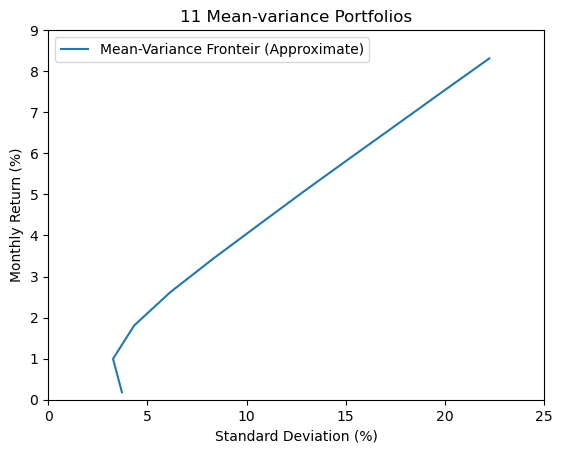

In [39]:
# Now let's plot the efficient fronteir

plt.plot(portfolio_summary.loc["stdev (%)", :], portfolio_summary.loc["Monthly Return (%)", :], label="Mean-Variance Fronteir (Approximate)")
plt.title("11 Mean-variance Portfolios")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Monthly Return (%)")
plt.xlim(0, 25)
plt.ylim(0, 9)
plt.legend()
plt.show()

***
## c) Bonus Question
> Assume that the riskfree rate is 0.1% per month. Figure out the tangency
portfolio. If your risk aversion coefficient is 10, and your utility function is the mean-variance
function as specified in class, what’s your optimal holding?

### The Tangency Portfolio

We wish to find the tangency portfolio. That is, we wish to find the portfolio that maximizes the Sharpe Ratio.

We can show that the maximum sharpe ratio portfolio really is the tangency portfolio by plotting the line with slope as the sharpe ratio and y-intercept as the risk-free rate.

We will modify the `minimum_variance_portfolio` code to find the portfolio with the highest sharpe

In [15]:
num_assets = 27
cov_mat = [list(cov_df.iloc[i, :].values) for i in range(27)]
mean_returns = monthly_returns.values
r_f = 0.001
def maximum_sharpe_portfolio(returns, expected_return=None):
    init_guess = np.ones(num_assets) / num_assets

    # get portfolio volaitity by multiplying weights to covariance matrix
    # note this is variance!
    def portfolio_volatility(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # get portfolio returns by multiplying weights to mean_returns
    def portfolio_return(weights, mean_returns):
        return np.dot(weights.T, mean_returns)

    # NEW - we return negative sharpe because we want to maximize (but function uses minimize())
    def portfolio_sharpe(weights, mean_returns, cov_matrix):
        return -(portfolio_return(weights, mean_returns) - r_f) / sqrt(portfolio_volatility(weights, cov_matrix))
        
    if expected_return is None:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    else:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                       {"type": "eq", "fun": lambda x: portfolio_return(x, mean_returns) - expected_return}]
    bounds = [(-10000000000, 100000000000) for i in range(num_assets)]
                # there're no bounds in weights, set to arbitrarily large numbers

    # encoding the linear program depicted in Slide 22
    result = minimize(fun=portfolio_sharpe,
                        x0=init_guess,
                        args=(returns, cov_mat),
                        method="SLSQP",
                        constraints=constraints,
                        bounds=bounds)

    # set variables to output
    w_max_sharpe = result.x
    ret_max_sharpe = np.sum(mean_returns * w_max_sharpe)
    max_sharpe = result.fun * -1
    std_max_sharpe = sqrt(portfolio_volatility(w_max_sharpe, cov_mat))
    return w_max_sharpe, ret_max_sharpe, std_max_sharpe, max_sharpe

In [16]:
w_max_sharpe, ret_max_sharpe, std_max_sharpe, max_sharpe = maximum_sharpe_portfolio(mean_returns)

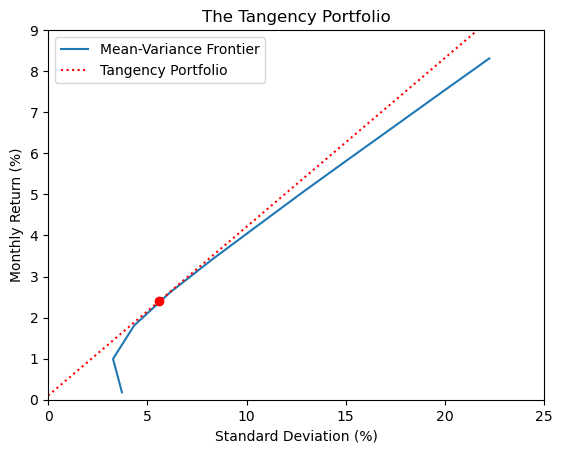

In [36]:
plt.plot(portfolio_summary.loc["stdev (%)", :], portfolio_summary.loc["Monthly Return (%)", :], label="Mean-Variance Frontier")

rf = [0, r_f * 100]
tang = [std_max_sharpe * 100, ret_max_sharpe * 100]
plt.axline(rf, tang, color='red', label="Tangency Portfolio", linestyle=':')
plt.plot([std_max_sharpe * 100], [ret_max_sharpe * 100], marker="o", color='red')
plt.title("The Tangency Portfolio")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Monthly Return (%)")
plt.xlim(0, 25)
plt.ylim(0, 9)
plt.legend()
plt.show()

### Portfolio Performance and Weights

In [18]:
tangent_portfolio_df = pd.DataFrame(columns = ["Permnos", "Stock Name(s)", "Weight"])
tangent_portfolio_df.iloc[:,0] = permnos.values
tangent_portfolio_df.loc[:, "Stock Name(s)"] = duplicate_comnam_df.COMNAM.values
tangent_portfolio_df.loc[:, "Weight"] = w_max_sharpe
tangent_portfolio_df.set_index("Permnos", inplace=True)

print(f"Average (monthly) return: {ret_max_sharpe*100:.4f}%")
print(f"Average (monthly) stdev: {std_max_sharpe*100:.4f}%")
print(f"Sharpe: {max_sharpe:.4f}")
tangent_portfolio_df["Weight"] = tangent_portfolio_df["Weight"].astype(float).round(4)
tangent_portfolio_df

Average (monthly) return: 2.4011%
Average (monthly) stdev: 5.5965%
Sharpe: 0.4112


,Stock Name(s),Weight
Permnos,,
10107,[MICROSOFT CORP],0.1246
10145,[HONEYWELL INTERNATIONAL INC],-0.0381
11308,[COCA COLA CO],-0.0693
12490,[INTERNATIONAL BUSINESS MACHS COR],-0.1467
14008,[AMGEN INC],0.0674
14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR...",-0.0619
14593,"[APPLE COMPUTER INC, APPLE INC]",0.3066
18163,[PROCTER & GAMBLE CO],0.2119
18542,[CATERPILLAR INC],0.1409


***
### The Optimal Portfolio for a risk aversion coefficient of `10`
We have our utility function is

$$ U\left(r\right) = E\left(r\right) - \dfrac{1}{2} \cdot A \cdot \sigma_r^2 $$

We just need to edit our optimization function from the tutorial to maximize the utility function

In [19]:
num_assets = 27
cov_mat = [list(cov_df.iloc[i, :].values) for i in range(27)]
mean_returns = monthly_returns.values
def maximum_utility_portfolio(returns, risk_aversion):
    init_guess = np.ones(num_assets) / num_assets

    # get portfolio volaitity by multiplying weights to covariance matrix
    # Note this is variance!
    def portfolio_volatility(weights, cov_matrix):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # get portfolio returns by multiplying weights to mean_returns
    def portfolio_return(weights, mean_returns):
        return np.dot(weights.T, mean_returns)

    # NEW - return negative since we use minimize but we want to find the maximum
    def portfolio_utility(weights, mean_returns, cov_matrix, risk_aversion):
        return -(portfolio_return(weights, mean_returns) - 0.5 * risk_aversion * portfolio_volatility(weights, cov_matrix))

    constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    bounds = [(-10000000000, 100000000000) for i in range(num_assets)]
                # there're no bounds in weights, set to arbitrarily large numbers

    # encoding the linear program depicted in Slide 22
    result = minimize(fun=portfolio_utility,
                        x0=init_guess,
                        args=(returns, cov_mat, risk_aversion),
                        method="SLSQP",
                        constraints=constraints,
                        bounds=bounds)

    # set variables to output
    w_max_util = result.x
    ret_max_util = np.sum(mean_returns * w_max_util)
    std_max_util = sqrt(portfolio_volatility(w_max_util, cov_mat))
    max_util = -result.fun
    return w_max_util, ret_max_util, std_max_util, max_util

In [20]:
A = 10
w_max_util, ret_max_util, std_max_util, max_util = maximum_utility_portfolio(mean_returns, A)

In [22]:
### Portfolio Performance and Weights
max_util_portfolio_df = pd.DataFrame(columns = ["Permnos", "Stock Name(s)", "Weight"])
max_util_portfolio_df.iloc[:,0] = permnos.values
max_util_portfolio_df.loc[:, "Stock Name(s)"] = duplicate_comnam_df.COMNAM.values
max_util_portfolio_df.loc[:, "Weight"] = w_max_util
max_util_portfolio_df.set_index("Permnos", inplace=True)

print(f"Average (monthly) return: {ret_max_util*100:.4f}%")
print(f"Average (monthly) stdev: {std_max_util*100:.4f}%")
print(f"Utility: {max_util:.4f}")
max_util_portfolio_df["Weight"] = max_util_portfolio_df["Weight"].astype(float).round(4)

Average (monthly) return: 1.9866%
Average (monthly) stdev: 4.6409%
Utility: 0.0091


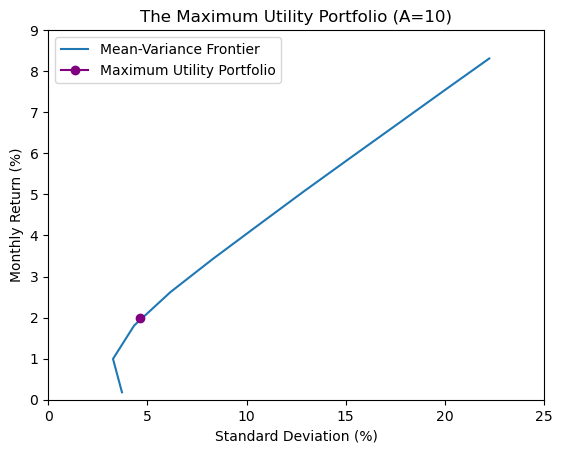

In [37]:
plt.plot(portfolio_summary.loc["stdev (%)", :], portfolio_summary.loc["Monthly Return (%)", :], label="Mean-Variance Frontier")
plt.plot([std_max_util * 100], [ret_max_util * 100], marker="o", color='purple', label="Maximum Utility Portfolio")
plt.title("The Maximum Utility Portfolio (A=10)")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Monthly Return (%)")
plt.xlim(0, 25)
plt.ylim(0, 9)
plt.legend()
plt.show()

In [24]:
# Weights
max_util_portfolio_df

,Stock Name(s),Weight
Permnos,,
10107,[MICROSOFT CORP],0.1032
10145,[HONEYWELL INTERNATIONAL INC],-0.0497
11308,[COCA COLA CO],-0.0090
12490,[INTERNATIONAL BUSINESS MACHS COR],-0.0971
14008,[AMGEN INC],0.0642
14541,"[CHEVRON CORP, CHEVRONTEXACO CORP, CHEVRON COR...",-0.0205
14593,"[APPLE COMPUTER INC, APPLE INC]",0.2287
18163,[PROCTER & GAMBLE CO],0.2126
18542,[CATERPILLAR INC],0.0910
